# Install

In [1]:
!pip install sentencepiece

# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Tue Feb  2 21:13:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc', 'quora']

In [7]:
# korean wiki dir
kowiki_dir = os.path.join(data_dir, 'kowiki')
if not os.path.exists(kowiki_dir):
    os.makedirs(kowiki_dir)
os.listdir(kowiki_dir)

['kowiki.txt.zip', 'my_corpus.txt', 'kowiki_lm.json', 'lm.csv']

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 256  # number of sequence
d_model = 256  # dimension of model

# 모델링

In [10]:
def build_model(n_vocab, d_model, n_seq):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장 길이 (단어 수)
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    # LSTM
    lstm = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden = lstm(hidden)  # (bs, n_seq, d_model * 2)
    # 다음단어 확률 분포
    dense = tf.keras.layers.Dense(n_vocab, activation=tf.nn.softmax)
    outputs = dense(hidden)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# All Data Project

## Data


In [11]:
def load_data(vocab, n_seq):
    """
    Language Model 학습 데이터 생성
    :param vocab: vocabulary object
    :param n_seq: number of sequence
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    # line 수 조회
    n_line = 0
    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for line in f:
            n_line += 1
    # 최대 100,000개 데이터
    n_data = min(n_line, 100000)
    # 빈 데이터 생성
    inputs = np.zeros((n_data, n_seq)).astype(np.int32)
    labels = np.zeros((n_data, n_seq)).astype(np.int32)

    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for i, line in enumerate(tqdm(f, total=n_data)):
            if i >= n_data:
                break
            data = json.loads(line)
            token_id = [vocab.piece_to_id(p) for p in data['token']]
            # input id
            input_id = [vocab.bos_id()] + token_id
            input_id += [0] * (n_seq - len(input_id))
            # label id
            label_id = token_id + [vocab.eos_id()]
            label_id += [0] * (n_seq - len(label_id))
            # 값 저장
            inputs[i] = input_id
            labels[i] = label_id

    return inputs, labels

In [12]:
# train data 생성
train_inputs, train_labels = load_data(vocab, n_seq)
train_inputs, train_labels

(array([[    2, 14473, 14639, ...,    24,   112,  6087],
        [    2,   138,   931, ...,   167,  8945,    59],
        [    2, 12780,    82, ...,    16,  2194,    43],
        ...,
        [    2,  7635,    47, ...,  8202,    16,   857],
        [    2, 22576,   156, ..., 17847,     1,  1030],
        [    2,   325, 14342, ...,    89,    23,   628]], dtype=int32),
 array([[14473, 14639,  2033, ...,   112,  6087,     3],
        [  138,   931,  6428, ...,  8945,    59,     3],
        [12780,    82,  3392, ...,  2194,    43,     3],
        ...,
        [ 7635,    47, 10990, ...,    16,   857,     3],
        [22576,   156,  9254, ...,     1,  1030,     3],
        [  325, 14342,  9766, ...,    23,   628,     3]], dtype=int32))

## Loss & Acc

In [13]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return loss

In [14]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    matches *= mask
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

## 학습

In [15]:
model = build_model(len(vocab), d_model, n_seq)

In [16]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [17]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 'lm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'lm.csv'))

In [18]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    epochs=2,
                    batch_size=32,  # oom이 발생하면 값을 줄여주세요.
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/2
3125/3125 [==============================] - 1530s 489ms/step - loss: 5.8188 - lm_acc: 0.0898

Epoch 00001: lm_acc improved from -inf to 0.12023, saving model to /content/drive/MyDrive/Data/nlp/kowiki/lm.hdf5
Epoch 2/2
3125/3125 [==============================] - 1556s 498ms/step - loss: 4.5553 - lm_acc: 0.1625

Epoch 00002: lm_acc improved from 0.12023 to 0.16883, saving model to /content/drive/MyDrive/Data/nlp/kowiki/lm.hdf5


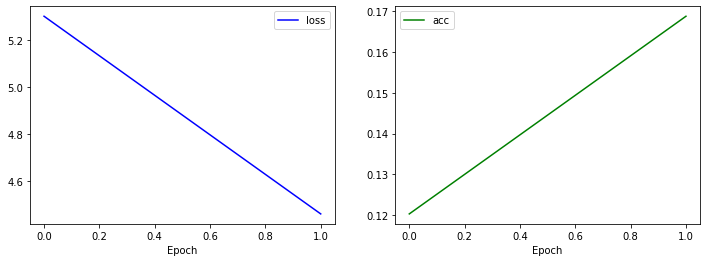

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()